In [1]:
import tensorflow as tf
from tensorflow.python.framework import graph_util

In [2]:
# ProtocolBufferファイルの作成
def freeze_graph(model_folder):
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    output_graph = model_folder + "/frozen_model.pb"

    output_node_names = "input,output,keep_prob"

    clear_devices = True
    
    # clear_devices=Trueで学習時のデバイスに依存しないようにする
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        output_graph_def = graph_util.convert_variables_to_constants(
            sess, 
            input_graph_def, 
            output_node_names.split(",") 
        ) 
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

In [3]:
freeze_graph('./RoadSign-Alexnet-spp-ckpt2/')

INFO:tensorflow:Restoring parameters from ./RoadSign-Alexnet-spp-ckpt2/roadsign_alex_spp
INFO:tensorflow:Froze 16 variables.
Converted 16 variables to const ops.
99 ops in the final graph.


In [4]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we can use again a convenient built-in function to import a graph_def into the 
    # current default Graph
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def, 
            input_map=None, 
            return_elements=None, 
            name="prefix", 
            op_dict=None, 
            producer_op_list=None
        )
    return graph

In [5]:
graph = load_graph('./RoadSign-Alexnet-spp-ckpt2/frozen_model.pb')

for op in graph.get_operations():
    print(op.name,op.outputs)

prefix/input [<tf.Tensor 'prefix/input:0' shape=(?, 150528) dtype=float32>]
prefix/keep_prob [<tf.Tensor 'prefix/keep_prob:0' shape=<unknown> dtype=float32>]
prefix/Reshape/shape [<tf.Tensor 'prefix/Reshape/shape:0' shape=(4,) dtype=int32>]
prefix/Reshape [<tf.Tensor 'prefix/Reshape:0' shape=(?, 224, 224, 3) dtype=float32>]
prefix/conv2d/kernel [<tf.Tensor 'prefix/conv2d/kernel:0' shape=(11, 11, 3, 96) dtype=float32>]
prefix/conv2d/kernel/read [<tf.Tensor 'prefix/conv2d/kernel/read:0' shape=(11, 11, 3, 96) dtype=float32>]
prefix/conv2d/bias [<tf.Tensor 'prefix/conv2d/bias:0' shape=(96,) dtype=float32>]
prefix/conv2d/bias/read [<tf.Tensor 'prefix/conv2d/bias/read:0' shape=(96,) dtype=float32>]
prefix/conv2d/convolution [<tf.Tensor 'prefix/conv2d/convolution:0' shape=(?, 56, 56, 96) dtype=float32>]
prefix/conv2d/BiasAdd [<tf.Tensor 'prefix/conv2d/BiasAdd:0' shape=(?, 56, 56, 96) dtype=float32>]
prefix/conv2d/Relu [<tf.Tensor 'prefix/conv2d/Relu:0' shape=(?, 56, 56, 96) dtype=float32>]
pr

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

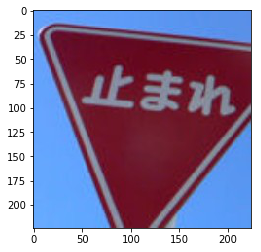

In [7]:
#　グラフのパラメータをpbファイルのパラメータで初期化
sess = tf.Session(graph=graph)

# 「止まれ」のサンプル画像
img = Image.open('./test_dataset_AlexNet/Stop-00190.jpg', "r")
plt.imshow(np.array(img))

input_data = np.frombuffer(np.array(img),dtype=np.uint8)
input_data = input_data.astype(np.float32)
input_data /= 255.0

In [8]:
# conv2dでのフィルタ適用後(出力)
conv2d = sess.run('prefix/conv2d/convolution:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
conv2d = conv2d.reshape(56, 56, 96)

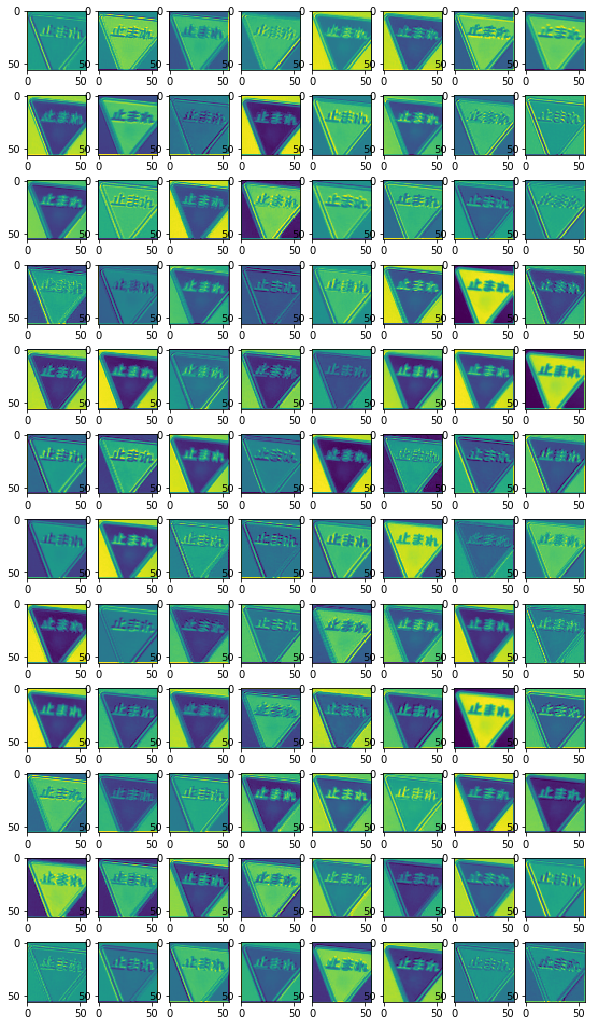

In [9]:
plt.figure(figsize=(10,20))
columns = 8
plot_num = 96
for i in range(0,plot_num):
    image = conv2d[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

In [10]:
# 入力のPlaceholderからと、conv2dからスタートしたものの出力が一致するか確認する
conv2d_2_tmp = sess.run('prefix/conv2d_2/convolution:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
conv2d_2 = sess.run('prefix/conv2d_2/convolution:0',{'prefix/conv2d/convolution:0':conv2d.reshape(1,56,56,96),'prefix/keep_prob:0':1.0})

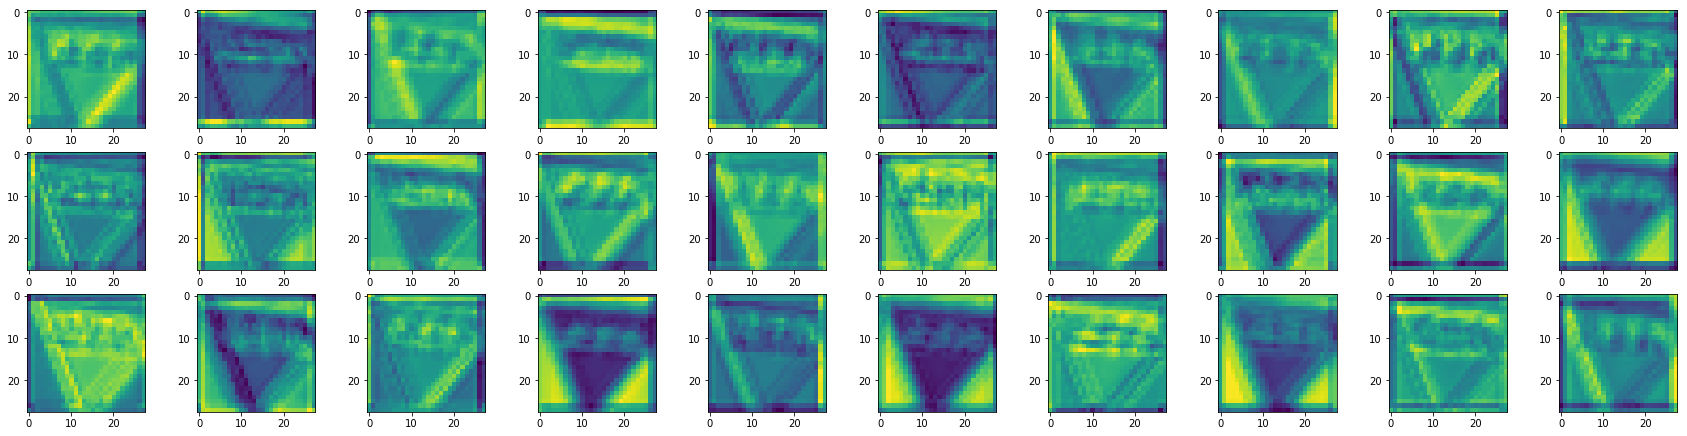

In [11]:
# Placeholder
conv2d_2_tmp  = conv2d_2_tmp.reshape(28,28,256)
plt.figure(figsize=(30,10))
columns = 10
plot_num = 30
for i in range(0,plot_num):
    image = conv2d_2_tmp[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

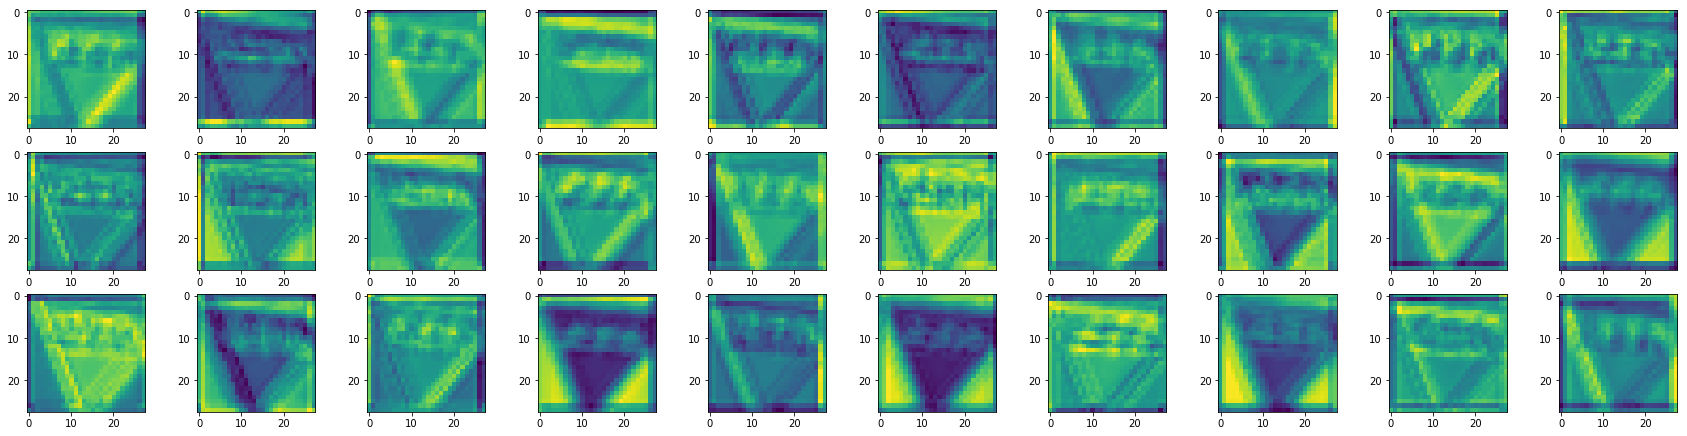

In [12]:
# placeholderからではなく、prefix/conv2d/convolution:0 に値を渡したもの
conv2d_2  = conv2d_2.reshape(28,28,256)
plt.figure(figsize=(30,10))
columns = 10
plot_num = 30
for i in range(0,plot_num):
    image = conv2d_2[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

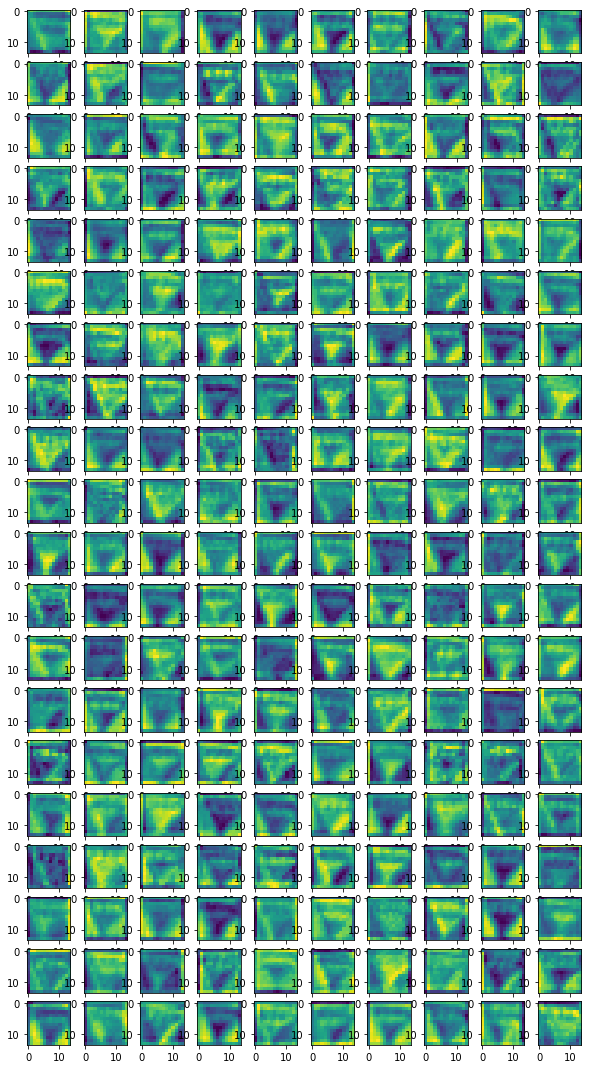

In [13]:
# prefix/conv2d_3/convolution [<tf.Tensor 'prefix/conv2d_3/convolution:0' shape=(?, 14, 14, 384) dtype=float32>]
# conv2d_3でのフィルタ適用後(出力)
conv2d_3 = sess.run('prefix/conv2d_3/convolution:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
conv2d_3  = conv2d_3.reshape(14,14,384)
plt.figure(figsize=(10,20))
columns = 10
plot_num = 200
for i in range(0,plot_num):
    image = conv2d_3[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

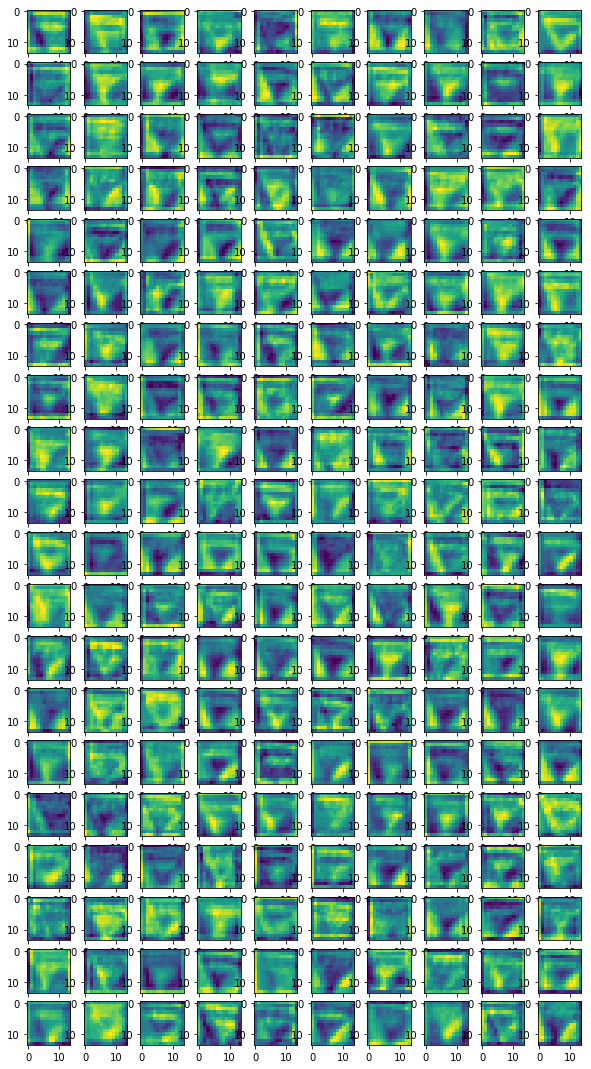

In [14]:
# prefix/conv2d_4/convolution [<tf.Tensor 'prefix/conv2d_4/convolution:0' shape=(?, 14, 14, 384) dtype=float32>]
# # conv2d_4でのフィルタ適用後(出力)
conv2d_4 = sess.run('prefix/conv2d_4/convolution:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
conv2d_4  = conv2d_4.reshape(14,14,384)
plt.figure(figsize=(10,20))
columns = 10
plot_num = 200
for i in range(0,plot_num):
    image = conv2d_4[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

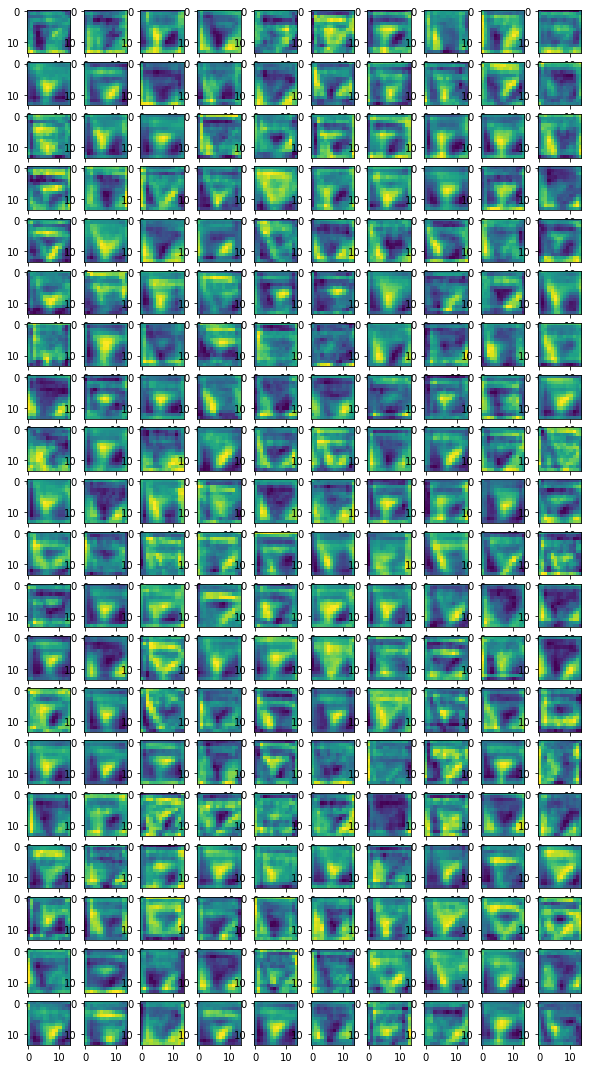

In [15]:
# prefix/conv2d_5/convolution [<tf.Tensor 'prefix/conv2d_5/convolution:0' shape=(?, 14, 14, 256) dtype=float32>]
# conv2d_5でのフィルタ適用後(出力)
conv2d_5 = sess.run('prefix/conv2d_5/convolution:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
conv2d_5  = conv2d_5.reshape(14,14,256)
plt.figure(figsize=(10,20))
columns = 10
plot_num = 200
for i in range(0,plot_num):
    image = conv2d_5[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

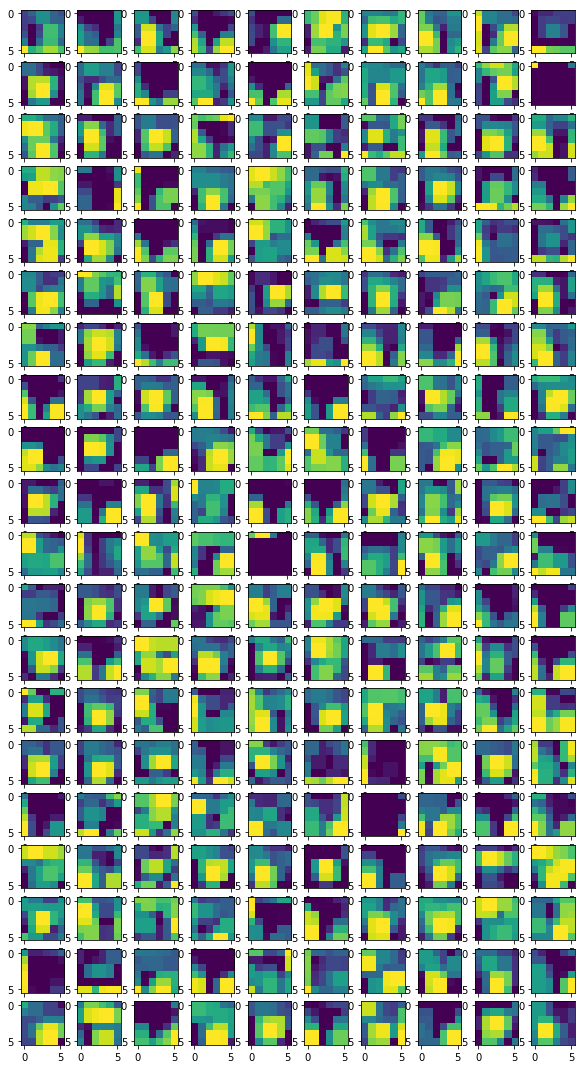

In [16]:
# prefix/max_pooling2d_6/MaxPool [<tf.Tensor 'prefix/max_pooling2d_6/MaxPool:0' shape=(?, 6, 6, 256) dtype=float32>]
# # conv2d_6でのフィルタ適用後(出力)
pool2d_6 = sess.run('prefix/max_pooling2d_6/MaxPool:0',{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})
pool2d_6  = pool2d_6.reshape(6,6,256)
plt.figure(figsize=(10,20))
columns = 10
plot_num = 200
for i in range(0,plot_num):
    image = pool2d_6[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

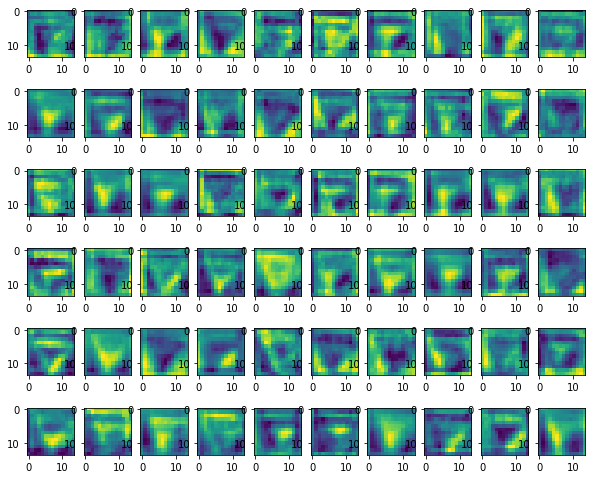

In [17]:
# prefix/concat [<tf.Tensor 'prefix/concat:0' shape=(?, 12800) dtype=float32>]
# SPP層適用後の出力
concat = sess.run('prefix/concat:0',{'prefix/conv2d_5/convolution:0':conv2d_5.reshape(1,14,14,256),'prefix/keep_prob:0':1.0})
concat  = concat.reshape(10,10,128)
plt.figure(figsize=(10,10))
columns = 10
plot_num = 60
for i in range(0,plot_num):
    image = conv2d_5[:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)

In [18]:
# prefix/conv2d/kernel/read [<tf.Tensor 'prefix/conv2d/kernel/read:0' shape=(11, 11, 3, 96) dtype=float32>]
# conv2dが持つ重み(フィルタ)の可視化(多分)
conv2d_weight = sess.run('prefix/conv2d/kernel/read:0' ,{'prefix/input:0':input_data.reshape(-1,224*224*3),'prefix/keep_prob:0':1.0})

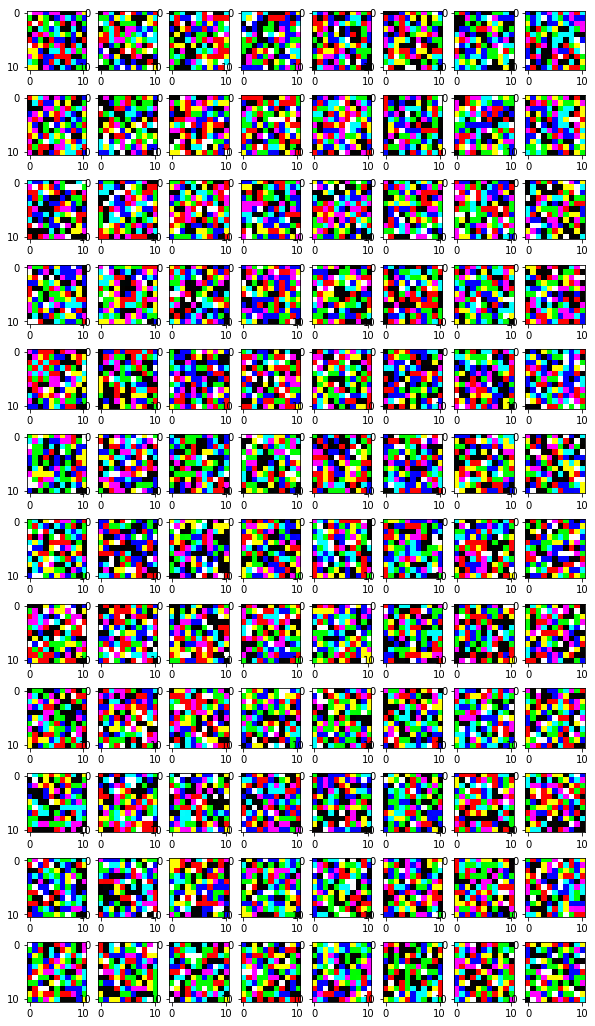

In [19]:
plt.figure(figsize=(10,20))
columns = 8
plot_num = 96
for i in range(0,plot_num):
    image = conv2d_weight[:,:,:,i]
    plt.subplot(plot_num / columns + 1, columns, i + 1)
    plt.imshow(image)